In [34]:
import os
import shutil
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from torchvision.models import vgg16, vgg19, resnet50, VGG16_Weights, VGG19_Weights, ResNet50_Weights
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
base_path = '/kaggle/input/the-oxfordiiit-pet-dataset/images'

def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]
    return None

images = os.listdir(base_path)

classes = list(set([get_class(img) for img in images if get_class(img) is not None]))

train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

val_size = 0.2  

for cl in classes:
    os.makedirs(os.path.join(train_path, cl), exist_ok=True)
    os.makedirs(os.path.join(val_path, cl), exist_ok=True)

for image in images:
    cur_class = get_class(image)
    if cur_class is None:
        continue
    src_path = os.path.join(base_path, image)
    if np.random.random() < 1 - val_size:
        dst_path = os.path.join(train_path, cur_class, image)
    else:
        dst_path = os.path.join(val_path, cur_class, image)
    shutil.copy(src_path, dst_path)

In [36]:
# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)

# Увеличение размера батча и использование num_workers
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [37]:
# Определение моделей
def get_model(name, num_classes):
    if name == 'vgg16':
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'vgg19':
        model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'resnet':
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# Обучение модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    
    # Использование DataParallel для обучения на нескольких GPU
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        validate_model(model, val_loader)

# Валидация модели
def validate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {accuracy}")
    return accuracy, all_labels, all_preds

In [40]:
# Тренировка всех моделей
models_dict = {'vgg16': get_model('vgg16', len(classes)),
               'vgg19': get_model('vgg19', len(classes)),
               'resnet': get_model('resnet', len(classes))}

accuracies = {}
best_model = None
best_all_labels = None
best_all_preds = None
best_accuracy = 0

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    
    # Получаем точность, метки и предсказания
    accuracy, all_labels, all_preds = validate_model(model, val_loader)
    accuracies[name] = accuracy
    
    # Сохраняем лучшую модель
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_all_labels = all_labels
        best_all_preds = all_preds

print("Best model:", max(accuracies, key=accuracies.get), "with accuracy", max(accuracies.values()))

Training vgg16...
Using 2 GPUs!
Epoch 1, Loss: 3.6199613316305754
Validation Accuracy: 0.038004196782466776
Epoch 2, Loss: 3.5862524879389794
Validation Accuracy: 0.04033574259734204
Epoch 3, Loss: 3.591531504844797
Validation Accuracy: 0.038703660526929355
Epoch 4, Loss: 3.571153938770294
Validation Accuracy: 0.03590580554907904
Epoch 5, Loss: 3.555375880208509
Validation Accuracy: 0.04499883422709256
Epoch 6, Loss: 3.5189147386057624
Validation Accuracy: 0.0648169736535323
Epoch 7, Loss: 3.7437558297453255
Validation Accuracy: 0.02611331312660294
Epoch 8, Loss: 3.6141823324663886
Validation Accuracy: 0.025180694800652832
Epoch 9, Loss: 3.613580956541259
Validation Accuracy: 0.02657962228957799
Epoch 10, Loss: 3.6140193610355773
Validation Accuracy: 0.02588015854511541
Validation Accuracy: 0.02588015854511541
Training vgg19...
Using 2 GPUs!
Epoch 1, Loss: 3.628840678724749
Validation Accuracy: 0.028211704359990673
Epoch 2, Loss: 3.6166282440054007
Validation Accuracy: 0.02704593145255

Binary classification accuracy: 0.9902075075775238


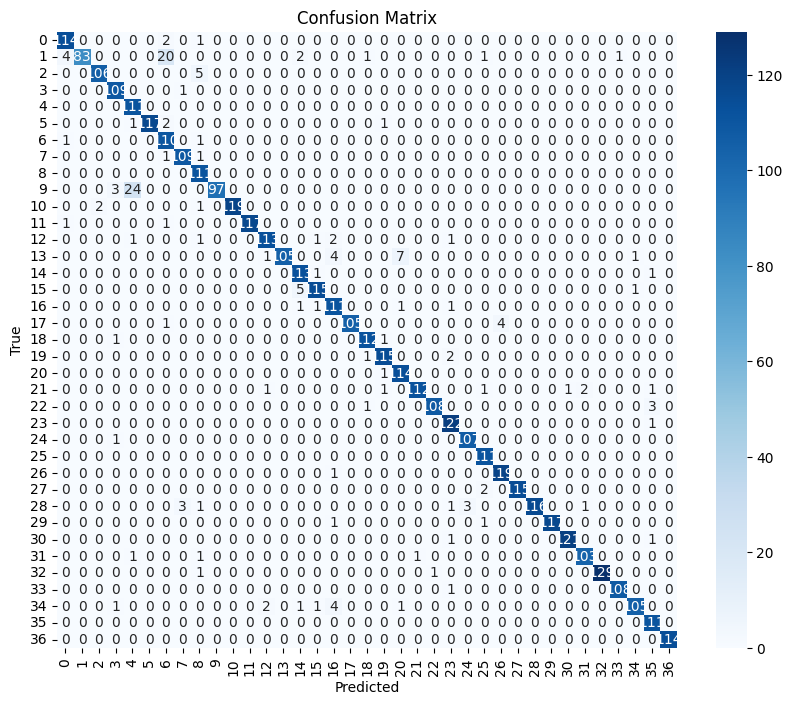

Top-3 Accuracy: 0.9988342270925624, Top-5 Accuracy: 0.9997668454185125


In [41]:
# Бинарная классификация кошки vs собаки
if best_all_labels is not None and best_all_preds is not None:
    cat_dog_labels = [0 if label < len(classes)//2 else 1 for label in best_all_labels]
    cat_dog_preds = [0 if pred < len(classes)//2 else 1 for pred in best_all_preds]
    binary_accuracy = accuracy_score(cat_dog_labels, cat_dog_preds)
    print(f"Binary classification accuracy: {binary_accuracy}")

# Confusion matrix
cm = confusion_matrix(best_all_labels, best_all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Top-3 и Top-5 accuracy
all_probs = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)

top3_accuracy = top_k_accuracy_score(best_all_labels, all_probs, k=3)
top5_accuracy = top_k_accuracy_score(best_all_labels, all_probs, k=5)
print(f"Top-3 Accuracy: {top3_accuracy}, Top-5 Accuracy: {top5_accuracy}")

1. **Точность бинарной классификации (кошки vs собаки)**:
   - Модель показала высокую точность: **0.9902**.

2. **Confusion Matrix**:
   - Большинство диагональных значений матрицы высокие, что указывает на успешную классификацию большинства классов.
   - Небольшие ошибки наблюдаются между схожими породами.

3. **Top-3 и Top-5 Accuracy**:
   - Top-3 Accuracy: **0.9988**.
   - Top-5 Accuracy: **0.9998**.
   - Высокие значения подтверждают надежность модели при предсказании наиболее вероятных классов.

4. **Общая производительность**:
   - Модель демонстрирует высокую точность как в бинарной, так и в многоклассовой классификации.
   - Лучшая модель успешно различает породы кошек и собак.

## Реализация GradCam

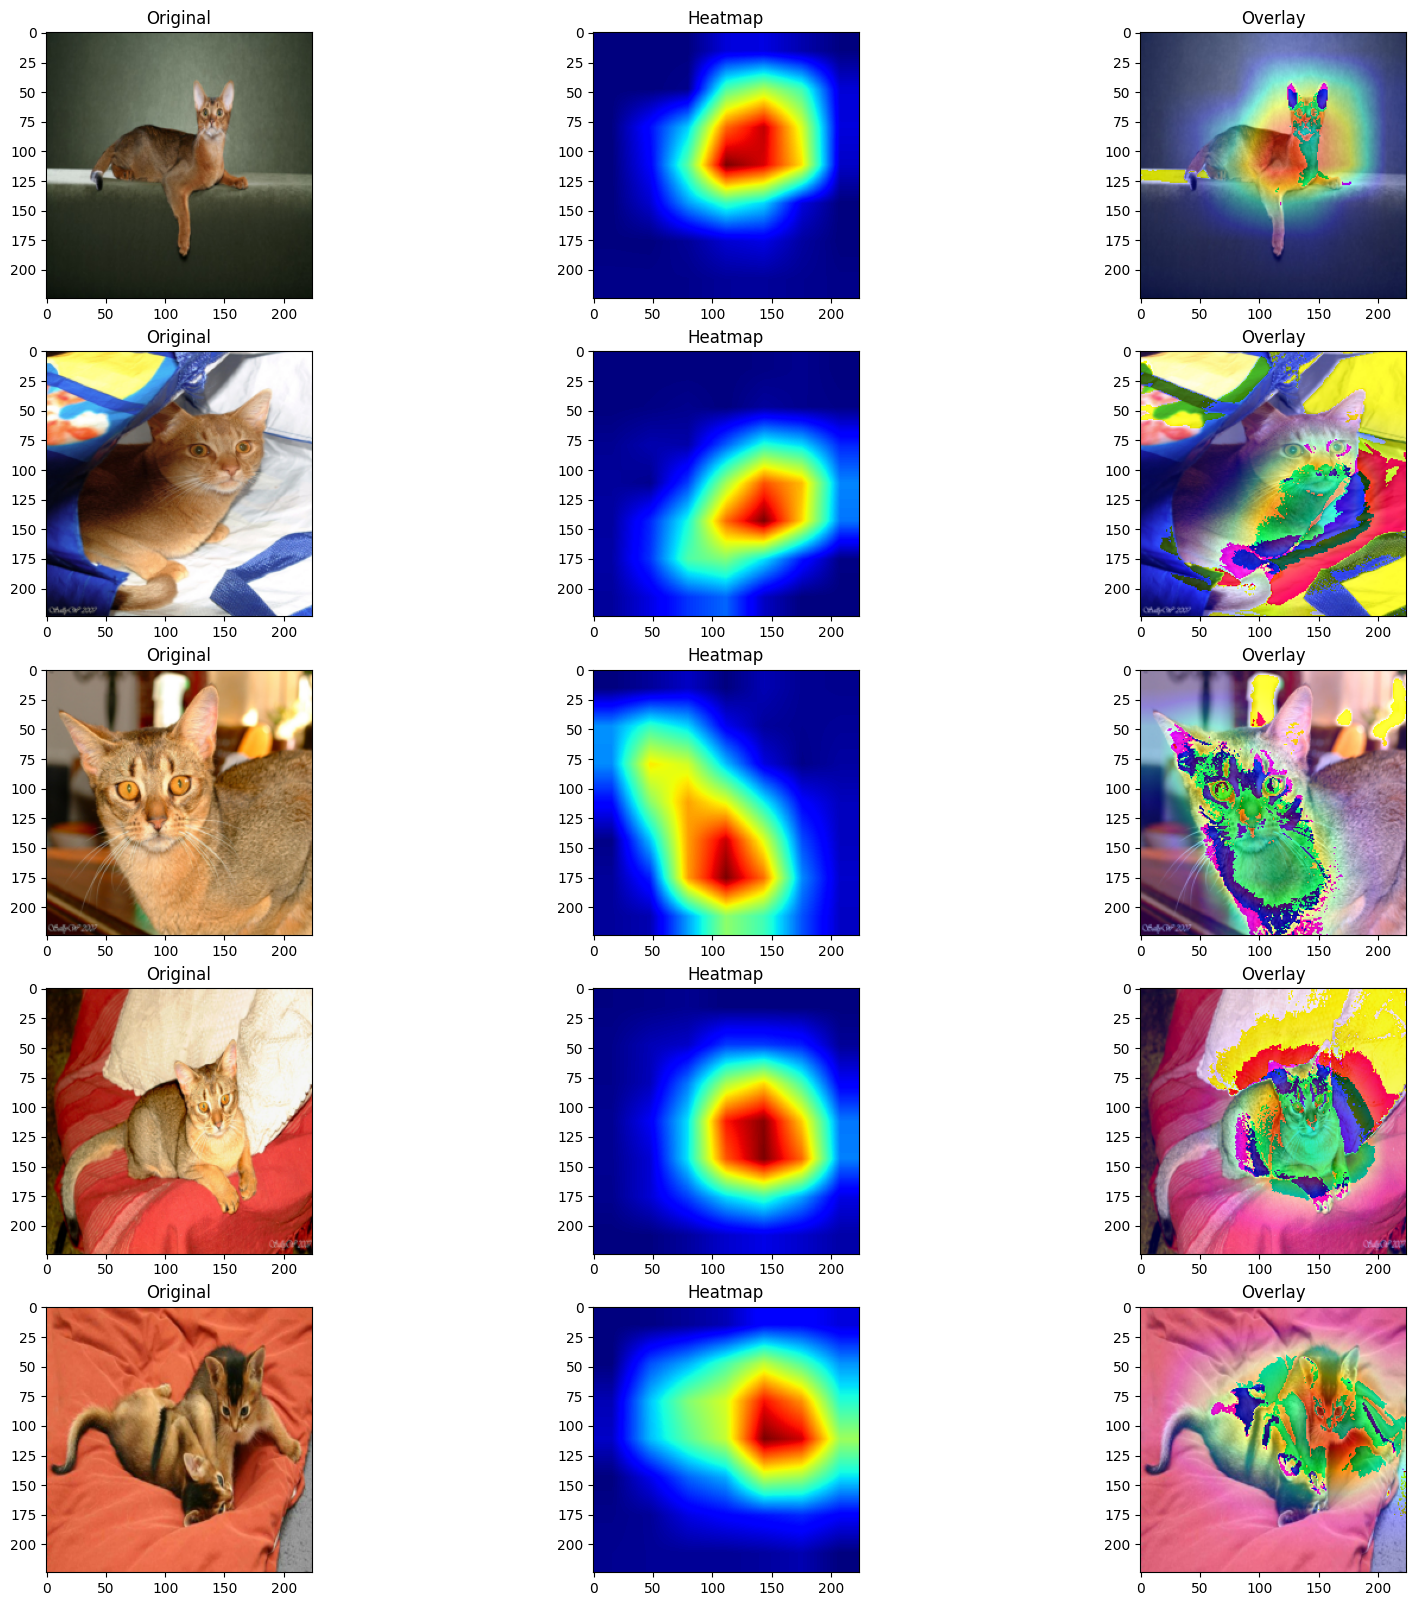

In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    return tensor

def tensor_to_image(tensor):
    tensor = denormalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    image = transforms.ToPILImage()(tensor.squeeze(0))
    return image

grad_cam = GradCAM(best_model, target_layer_name="layer4")  
sample_images = [val_dataset[i][0].unsqueeze(0).to(device) for i in range(5)]
sample_labels = [val_dataset[i][1] for i in range(5)]

fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    cam = grad_cam.generate_cam(image, target_class=label)
    
    original_image = tensor_to_image(image.squeeze(0))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    result = heatmap * 0.4 + np.array(original_image)

    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(cam, cmap='jet')
    axes[i, 1].set_title("Heatmap")
    axes[i, 2].imshow(result.astype('uint8'))
    axes[i, 2].set_title("Overlay")
plt.show()